In [17]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import rasterio
import seaborn as sns

from scipy import ndimage
from scipy.optimize import minimize
from scipy.optimize import Bounds

import sys
sys.path.append('../func')
from wrapper_rasterio import export_tiff
from arc_sinc import arc_sinc

plt.rcParams.update({'font.size':12})

In [18]:
def calc_rmse(X,Y):
    return np.sqrt(((X-Y)**2).mean())

# Litchfield forest

In [19]:
gt_lidar = rasterio.open(f'data/lidar/litchfield/square_canopy_50m_from_10m_lanczos.tif').read(1)
coh_hv = rasterio.open('data/alos2/litchfield_int_coh_20150314_20150326_28352_clp.tif').read(2)
gt_show = gt_lidar.copy()
gt_show[gt_show < 0] = np.nan

## Distribution check

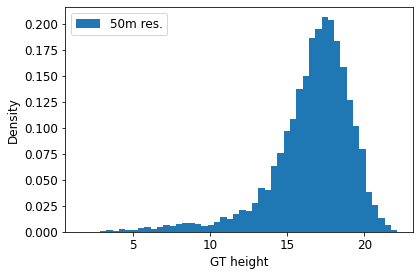

In [4]:
plt.hist(gt_lidar[gt_lidar > 0], bins=50, label=f'50m res.', density=True)
plt.legend()
plt.xlabel('GT height')
plt.ylabel('Density')
plt.tight_layout()
# plt.savefig(f'figure/dist_gt_50m_lanczos.png')
plt.show()

/home/ketak/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


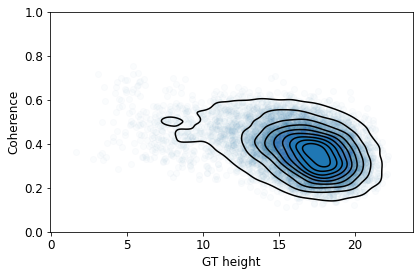

In [5]:
mask_use = gt_lidar > 0
X = gt_lidar[mask_use]
Y = coh_hv[mask_use]

plt.scatter(X, Y, alpha=0.02)
n_show = mask_use.sum()
ind_show = np.random.choice(np.arange(n_show),replace=False, size=min(20000, n_show))
sns.kdeplot(X[ind_show], Y[ind_show], color='black')
# plt.xlim(15, 30)
plt.xlabel('GT height')
plt.ylabel('Coherence')
plt.ylim(0,1)
plt.tight_layout()
# plt.savefig('figure/gt_vs_coh.png')
plt.show()

## Train the model

Find the parameters $S$ and $C$ as the minimizers of the following optimization problem:  

$\min_{S,C} (h_t - C*\mathrm{arc sinc }(\gamma/S))^2$  
s.t. $C>0$ and $0\leq S\leq 1$,  

where $h_t$ is the height from GT and $\gamma$ is the coherence.


Define the loss function.   
Because there is no numpy/scipy implementation of arcsinc, we use the one implemeted by the author of the paper.  
https://github.com/synspective/green-dakara/blob/master/simplified_rvog/script/arc_sinc.py

In [6]:
def loss_sinc_model(theta, coh, ht_gt):
    ht_est = arc_sinc(coh/theta[0], theta[1])
    loss = np.mean(((ht_est-ht_gt)/ht_gt)**2)

    return loss

Split the GT into train and validation data to evaluate the model performance.  
Here we try 4 different ways of splitting

In [23]:
# Set the windows for splitting the GT into train and valid
ht_lb, ht_ub = np.percentile(gt_lidar[gt_lidar > 0], [0, 99.5])
ysize, xsize = gt_lidar.shape
windows = [[[0,50,0,xsize], [50, ysize, 0, xsize]],
          [[50,ysize,0,xsize], [0,50,0,xsize]],
          [[0,ysize,0,50],[0,ysize,50,xsize]],
          [[0,ysize,50,xsize],[0,ysize,0,50]]
          ]

In [31]:
i_window = 3 # Select the window type

window = windows[i_window][0]
mask_train = np.zeros_like(gt_lidar, dtype=np.int8)
mask_train[window[0]:window[1], window[2]:window[3]] = 1
mask_train[(gt_lidar < ht_lb) | (gt_lidar > ht_ub)] = 0
coh_hv_train, gt_lidar_train = coh_hv[mask_train==1], gt_lidar[mask_train==1]

theta0 = np.array([0.6, 13])
bounds = Bounds([0.6, 7], [1, 17]) # Be careful about the order
res = minimize(loss_sinc_model, theta0, args=(coh_hv_train, gt_lidar_train), method='trust-constr',
               options={'disp': True},bounds=bounds)
S_est,C_est = res.x
print(res.x)

`gtol` termination condition is satisfied.
Number of iterations: 22, function evaluations: 42, CG iterations: 22, optimality: 3.39e-09, constraint violation: 0.00e+00, execution time: 0.11 s.
[0.7863637  7.40584717]


Get the estimated tree height by  
$\hat{h}_t = \hat{C}\cdot\mathrm{arcsinc}(\gamma/\hat{S})$

RMSE: 2.85
GT Mean: 17.29
Est Mean: 15.48


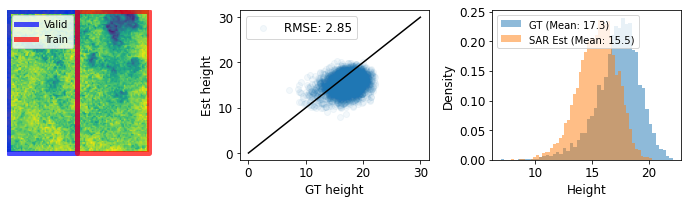

In [25]:
ht_est = arc_sinc(coh_hv/S_est, C_est) 

mask_valid = (mask_train==0) & (gt_lidar > 0)
X = gt_lidar[mask_valid]
Y = ht_est[mask_valid]
print(f'RMSE: {calc_rmse(X,Y):.2f}')
print(f'GT Mean: {X.mean():.2f}')
print(f'Est Mean: {Y.mean():.2f}')

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(gt_show)
window_train = windows[i_window][0]
window_valid = windows[i_window][1]
plt.plot([window_valid[2],window_valid[3],window_valid[3],window_valid[2],window_valid[2]], [window_valid[0],window_valid[0],window_valid[1],window_valid[1],window_valid[0]],lw='5',color='blue', alpha=0.7, label='Valid')
plt.plot([window_train[2],window_train[3],window_train[3],window_train[2],window_train[2]], [window_train[0],window_train[0],window_train[1],window_train[1],window_train[0]],lw='5',color='red', alpha=0.7, label='Train')

plt.axis('off')
plt.legend(fontsize=10,loc=2)
# plt.show()

plt.subplot(132)
plt.scatter(X, Y, alpha=0.05, label=f'RMSE: {calc_rmse(X,Y):.2f}')
xx = np.linspace(0,30,100)
plt.plot(xx,xx,color='black')
plt.xlabel('GT height')
plt.ylabel('Est height')
plt.legend(loc=2)

plt.subplot(133)
plt.hist(X, bins=50, alpha=0.5, label=f'GT (Mean: {X.mean():.1f})', density=True)
plt.hist(Y, bins=50, alpha=0.5, label=f'SAR Est (Mean: {Y.mean():.1f})', density=True)
plt.legend(fontsize=10, loc=2)
plt.xlabel('Height')
plt.ylabel('Density')

plt.tight_layout()
# plt.savefig(f'figure/res_window_{i_window}.png')
plt.show()

Train the model using the whole sample

**(Investigation needed)**
Because the optimized parameters are not on the boundaries, they should not change if the boundaries change a bit.  However, they do change according to the boundary values.  
As a temporary solution, here we try various sets of boundaries and find the one achieving the minimal loss value.

In [117]:
# from sklearn.utils.extmath import cartesian
# theta1_cand = np.arange(0.5,1,0.05)
# theta2_cand = np.arange(4,7,0.25)
# theta3_cand = np.arange(10,17,1)

# bounds_check = cartesian((theta1_cand,theta2_cand, theta3_cand))

# loss_opt = []

# for b_check in bounds_check:
#     d1,d2,d3 = b_check
#     bounds = Bounds([d1, d2], [1, d3])
#     res = minimize(loss_sinc_model, theta0, args=(coh_hv_full, gt_lidar_train_full), method='trust-constr',
#                    options={'disp': False},
#                   bounds=bounds)
#     loss_opt.append(res.fun)
# print(bounds_check[np.array(loss_opt).argmin()])

The optimal constraint was:  
bounds = Bounds([0.6, 6.5], [1, 16])

In [32]:
gt_lidar_train_full = gt_lidar[gt_lidar > 0]
coh_hv_full = coh_hv[gt_lidar > 0]

theta0 = np.array([0.6, 13])
bounds = Bounds([0.6, 6.5], [1, 16])
res = minimize(loss_sinc_model, theta0, args=(coh_hv_full, gt_lidar_train_full), method='trust-constr',
               options={'disp': True}, bounds=bounds)
S_est_full,C_est_full = res.x
print(res.x)

`gtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 105, CG iterations: 44, optimality: 2.22e-09, constraint violation: 0.00e+00, execution time: 0.22 s.
[0.84979384 7.37774791]


# Albany eucalyptus plantation

Apply the trained model to the Oji plantation area in Albany

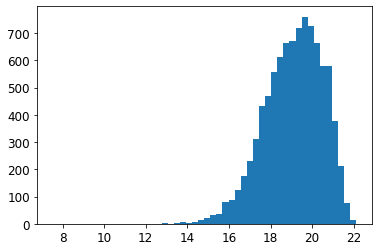

In [33]:
label_plant = rasterio.open('data/label/Albany_ht_est.tif').read(1)
coh_hv = rasterio.open('data/alos2/albany_int_coh_20201016_20211015_28350_clp.tif').read(2)
ht_est_albany = arc_sinc(coh_hv/S_est_full, C_est_full)
plt.hist(ht_est_albany[label_plant==1], bins=50)
plt.show()

Export the estimated tree height map in a geotiff file

In [22]:
nodata_value = -9999
array = np.empty_like(label_plant, dtype=np.float32)
array[label_plant==0] = nodata_value
array[label_plant==1] = ht_est_albany[label_plant==1]
export_tiff(array, target='result/forest_height_est.tif', 
            reference='data/label/Albany_ht_est.tif', 
            nodata=nodata_value)

In [42]:
# # plt.scatter(coh_hv[label_plant==1], amp_hv_slv[label_plant==1], alpha=0.002)
# sns.kdeplot(coh_hv[label_plant==1], amp_hv_slv[label_plant==1])
# plt.xlim(0,0.7)
# plt.ylim(0,0.07)
# plt.xlabel('Coherence')
# plt.ylabel('Backscatter coeffient')
# plt.tight_layout()
# plt.savefig('figure/coh_vs_bs_albany.png')
# plt.show()

In [43]:
# plt.hist(coh_hv.flatten(), bins=50, density=True)
# plt.xlabel('Coherence')
# plt.ylabel('Density')
# # plt.xlim(0,0.12)
# plt.tight_layout()
# plt.savefig(f'figure/dist_coh_albany.png')
# plt.show()